# Land & Road Transport Statistics – Saudi Arabia (2021–2024)

In this notebook we explore official **land / road transport statistics** from stats.gov.sa.

Goals:

- Understand what each table shows in **simple terms**.
- Clean the data so that each table is easy to use.
- Plot trends to help the audience see **how transport is changing over time**.
- Compare **registered vehicles vs. public transport bus passengers**.
- Highlight a few **key insights** that link to congestion and safety.

We will use three main tables:

1. **Registered vehicles** (2022–2024) – national totals (file: *Road Transport Statistics 2024*).
2. **Public transport bus passengers (within cities vs intercity)** – 2021–2024 totals.
3. **Bus passengers by city (within cities)** – latest year breakdown by major cities.

In [15]:
# 0. Imports and file paths

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Show plots inside the notebook
%matplotlib inline

# Assume the Excel files are in the SAME folder as this notebook.
# If they are in a subfolder, change DATA_DIR accordingly.
DATA_DIR = Path("..") / "data"

file_2022 = DATA_DIR / "Land Transport Statistics table 2022-EN.xlsx"
file_2024 = DATA_DIR / "Rroad Transport Statistics 2024_EN (1).xlsx"

# Load workbooks (just once)
xls_2022 = pd.ExcelFile(file_2022)
xls_2024 = pd.ExcelFile(file_2024)

## 1. Quick overview of the workbooks

Here we only look at the sheet names to understand:

- The **structure** of each file.
- How many separate tables are inside.
- Which sheet numbers we will focus on.

We will not go through all sheets now – only log them to see how rich the data is.

In [16]:
# List sheet names for each file (for your own understanding)
print("Sheets in 2022 workbook:")
print(xls_2022.sheet_names)

print("\nSheets in 2024 workbook:")
print(xls_2024.sheet_names)

Sheets in 2022 workbook:
['Index', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']

Sheets in 2024 workbook:
['Index', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '3-1', '3-2', '3-3', '3-4', '3-5', '3-6', '4-1', '4-2', '4-3', '4-4', '4-5', '4-6', '4-7', '4-8', '5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '6-1', '6-2', '6-3', '6-4', '6-5', '6-6', '7-1', '7-2', '7-3', '7-4', '7-5', '7-6', '7-7', '7-8', '7-9', '7-10', '7-11', '7-12', '7-13', '7-14', '7-15', '8-1', '8-2']


## 2. Registered vehicles – national totals (2022–2024)

We start with a simple but powerful question:

> How many **registered vehicles** are in operation in Saudi Arabia, and how fast is this number growing?

The 2024 workbook has a table (sheet **`4-2`**) called  
**“Number of registered vehicles in operation by year”**.

Steps:

1. Load sheet `4-2`.
2. Keep only the rows with real data (years and counts).
3. Convert columns to the right types.
4. Compute **year-over-year (YoY) growth**.
5. Plot a simple line chart.

In [17]:
# 2.1 Load and clean the "registered vehicles" table (sheet 4-2 in 2024 file)

vehicles_raw = xls_2024.parse("4-2", header=5)  # header row is around row 6
display(vehicles_raw)

# Keep only numeric year rows and drop the "Source" row
vehicles = vehicles_raw.dropna(subset=["Year"]).copy()
vehicles = vehicles[vehicles["Year"].astype(str).str.contains(r"\d")].copy()

# Convert types
vehicles["Year"] = vehicles["Year"].astype(int)
vehicles["Number of vehicles"] = pd.to_numeric(
    vehicles["Number of vehicles"], errors="coerce"
)
vehicles = vehicles.dropna(subset=["Number of vehicles"]).copy()
vehicles["Number of vehicles"] = vehicles["Number of vehicles"].astype(int)

# Sort and compute YoY growth (%)
vehicles = vehicles.sort_values("Year").reset_index(drop=True)
vehicles["vehicles_yoy_pct"] = vehicles["Number of vehicles"].pct_change() * 100

display(vehicles)

,Year,Number of vehicles
0,2022,14261163.0
1,2023,14857432.0
2,2024,15883570.0
3,Source: Ministerial Committee for Traffic Safe...,NaN


,Year,Number of vehicles,vehicles_yoy_pct
0,2022,14261163,NaN
1,2023,14857432,4.181069
2,2024,15883570,6.906564


### 2.2 Plot: Registered vehicles over time

This chart helps the audience see:

- The **absolute growth** in vehicles.
- Whether growth is **speeding up or slowing down**.

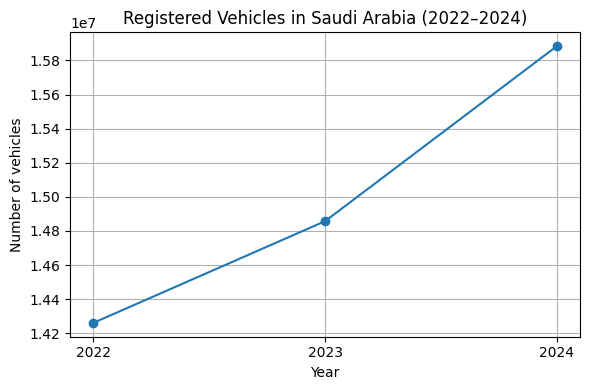

In [25]:
plt.figure(figsize=(6, 4))

# Ensure year is integer and use it for both x values and tick labels
years = vehicles["Year"].astype(int)

plt.plot(years, vehicles["Number of vehicles"], marker="o")
plt.title("Registered Vehicles in Saudi Arabia (2022–2024)")
plt.xlabel("Year")
plt.ylabel("Number of vehicles")
plt.grid(True)

# Force clean year ticks
plt.xticks(years)

plt.tight_layout()
plt.show()


## 3. Public transport bus passengers – totals (2021–2024)

Next question:

> How is **bus usage** changing over time, within cities and between cities?

The 2024 workbook has a table (sheet **`1-2`**) that looks like:

- **Year**
- **Unit** (Million passengers)
- **Within cities**
- **Intercity**

We will:

1. Load sheet `1-2`.
2. Clean column names and values.
3. Compute **total passengers** and **growth rates**.
4. Plot trends in bus usage.

In [19]:
# 3.1 Load and clean bus passenger totals (sheet 1-2 in 2024 file)

bus_summary_raw = xls_2024.parse("1-2", header=5)
display(bus_summary_raw)

# Clean column names: lower case, strip spaces, replace spaces with underscores
bus_summary = bus_summary_raw.copy()
bus_summary.columns = (
    bus_summary.columns.str.strip().str.lower().str.replace(" ", "_")
)

# Keep only rows where 'year' looks like a number (drop the source row)
bus_summary = bus_summary[bus_summary["year"].astype(str).str.contains(r"\d")].copy()

# Convert types
bus_summary["year"] = bus_summary["year"].astype(int)
for col in ["within_cities", "intercity"]:
    bus_summary[col] = pd.to_numeric(bus_summary[col], errors="coerce")

bus_summary = bus_summary.dropna(subset=["within_cities", "intercity"]).copy()

# Total passengers (in million)
bus_summary["total_million_passengers"] = (
    bus_summary["within_cities"] + bus_summary["intercity"]
)

# Sort and compute YoY growth (%)
bus_summary = bus_summary.sort_values("year").reset_index(drop=True)
for col in ["within_cities", "intercity", "total_million_passengers"]:
    bus_summary[f"{col}_yoy_pct"] = bus_summary[col].pct_change() * 100

display(bus_summary)

,Year,Unit,within cities,Intercity
0,2021,Million passenger,9.8,3.10
1,2022,Million passenger,38.5,4.10
2,2023,Million passenger,113.5,4.10
3,2024,Million passenger,104.4,3.49
4,Transport General Authority,NaN,NaN,NaN


,year,unit,within_cities,intercity,total_million_passengers,within_cities_yoy_pct,intercity_yoy_pct,total_million_passengers_yoy_pct
0,2021,Million passenger,9.8,3.10,12.90,NaN,NaN,NaN
1,2022,Million passenger,38.5,4.10,42.60,292.857143,32.258065,230.232558
2,2023,Million passenger,113.5,4.10,117.60,194.805195,0.000000,176.056338
3,2024,Million passenger,104.4,3.49,107.89,-8.017621,-14.878049,-8.256803


### 3.2 Plot: Bus passengers (within cities vs intercity)

This plot answers:

- How much bus use has **grown** from 2021 to 2024.
- The **balance** between within-city trips and intercity trips.

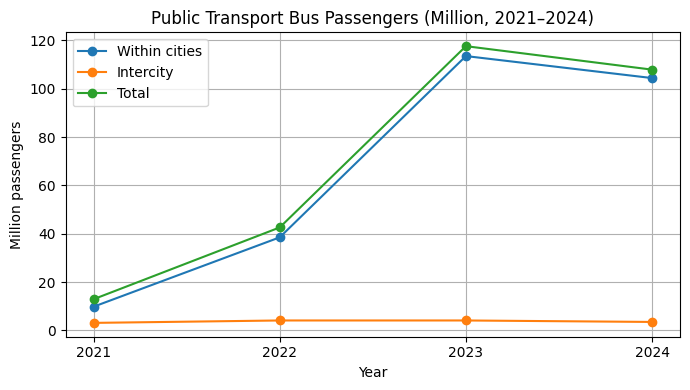

In [26]:
plt.figure(figsize=(7, 4))

years = bus_summary["year"].astype(int)

plt.plot(years, bus_summary["within_cities"], marker="o", label="Within cities")
plt.plot(years, bus_summary["intercity"], marker="o", label="Intercity")
plt.plot(
    years,
    bus_summary["total_million_passengers"],
    marker="o",
    label="Total",
)

plt.title("Public Transport Bus Passengers (Million, 2021–2024)")
plt.xlabel("Year")
plt.ylabel("Million passengers")
plt.legend()
plt.grid(True)

plt.xticks(years)

plt.tight_layout()
plt.show()

## 4. Public transport bus passengers by city (latest year)

Now we zoom in on **cities**:

> Which cities have the **highest number of bus passengers within cities**?

Sheet **`1-3`** in the 2024 workbook gives:

- Location (within cities / intercity)
- Region
- City
- Number of passengers

We will:

1. Load sheet `1-3`.
2. Keep only **“within cities”** rows with a real city name.
3. Compute each city’s **share of total passengers**.
4. Plot the **top cities** to show where bus usage is concentrated.

In [30]:
# 4.1 Load and clean city-level bus passenger table (sheet 1-3 in 2024 file)

city_bus_raw = xls_2024.parse("1-3", header=5)
display(city_bus_raw.head(15))

city_bus = city_bus_raw.copy()
city_bus.columns = (
    city_bus.columns.str.strip().str.lower().str.replace(" ", "_")
)

# Fill down 'location' (so all within-city rows are labeled)
city_bus["location"] = city_bus["location"].ffill()

# Keep rows with real region and city, and remove 'Total' / source rows
city_bus_clean = city_bus[
    city_bus["region"].notna()
    & city_bus["city"].notna()
    & ~city_bus["region"].str.contains("Total", case=False, na=False)
    & ~city_bus["city"].str.contains("Total", case=False, na=False)
].copy()

# Focus on "within cities" block
city_within = city_bus_clean[
    city_bus_clean["location"].str.lower() == "within cities"
].copy()

# Convert passengers to integer
city_within["number_of_passengers"] = pd.to_numeric(
    city_within["number_of_passengers"], errors="coerce"
)
city_within = city_within.dropna(subset=["number_of_passengers"]).copy()
city_within["number_of_passengers"] = city_within["number_of_passengers"].astype(int)

# Compute city share of total within-city passengers
total_within = city_within["number_of_passengers"].sum()
city_within["share_pct"] = (
    city_within["number_of_passengers"] / total_within * 100
)

# Sort by passengers (largest first)
city_within = city_within.sort_values(
    "number_of_passengers", ascending=False
).reset_index(drop=True)

display(city_within)

,Location,Region,City,Number of passengers
0,within cities,Riyadh,Riyadh,34723559.0
1,NaN,Makkah,Makkah,59546368.0
2,NaN,Makkah,Jeddah,4697856.0
3,NaN,Makkah,Taif,625912.0
4,NaN,Madinah,Madinah,1727635.0
5,NaN,Qassim,"Buraidah, Unaizah, Al-Rass",297641.0
6,NaN,Eastern Region,"Dammam, Al-Khobar, Dhahran, and Al-Qatif",2500392.0
7,NaN,Jazan,"Jazan, Sabya, Abu Arish, Farasan Island",247529.0
8,NaN,Total,NaN,104366892.0
9,Intercity,Northern concession area,NaN,737136.0


,location,region,city,number_of_passengers,share_pct
0,within cities,Makkah,Makkah,59546368,57.054845
1,within cities,Riyadh,Riyadh,34723559,33.270665
2,within cities,Makkah,Jeddah,4697856,4.501290
3,within cities,Eastern Region,"Dammam, Al-Khobar, Dhahran, and Al-Qatif",2500392,2.395771
4,within cities,Madinah,Madinah,1727635,1.655348
5,within cities,Makkah,Taif,625912,0.599723
6,within cities,Qassim,"Buraidah, Unaizah, Al-Rass",297641,0.285187
7,within cities,Jazan,"Jazan, Sabya, Abu Arish, Farasan Island",247529,0.237172


### 4.2 Plot: Top cities by in-city bus passengers

This chart is useful to show:

- Which cities **dominate** in terms of bus ridership.
- How important **Riyadh** is relative to other major cities.

(We plot the top 5 cities for simplicity.)

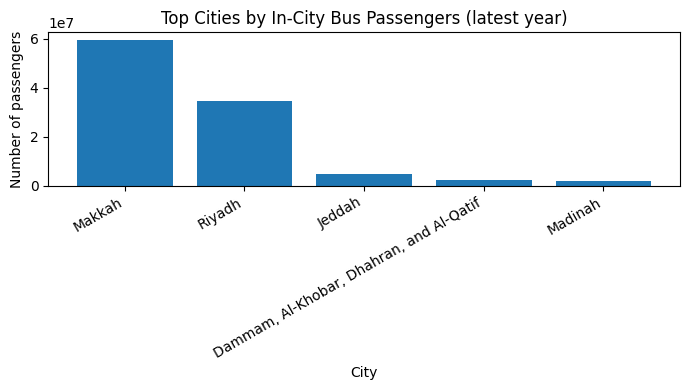

In [29]:
top_cities = city_within.head(5)

plt.figure(figsize=(7, 4))
plt.bar(top_cities["city"], top_cities["number_of_passengers"])
plt.title("Top Cities by In-City Bus Passengers (latest year)")
plt.xlabel("City")
plt.ylabel("Number of passengers")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## 5. Comparing vehicles and bus passengers (2022–2024)

Now we combine two views:

- **Registered vehicles** (private car side of the story).
- **Bus passengers** (public transport side of the story).

Question:

> Are bus passenger numbers growing in line with the growth in registered vehicles?

We will:

1. Merge the vehicles table (2022–2024) with bus totals (2022–2024).
2. Compute a simple indicator:  
   **bus passengers per registered vehicle** (approximate).
3. Plot this indicator over time.

In [23]:
# 5.1 Merge vehicles and bus passenger totals for 2022–2024

vehicles_clean = vehicles.rename(
    columns={"Year": "year", "Number of vehicles": "registered_vehicles"}
)

merged = pd.merge(
    vehicles_clean[["year", "registered_vehicles", "vehicles_yoy_pct"]],
    bus_summary[["year", "total_million_passengers"]],
    on="year",
    how="inner",
)

# Passengers per vehicle (convert million passengers to raw count)
merged["passengers_per_vehicle"] = (
    merged["total_million_passengers"] * 1_000_000
) / merged["registered_vehicles"]

display(merged)

,year,registered_vehicles,vehicles_yoy_pct,total_million_passengers,passengers_per_vehicle
0,2022,14261163,NaN,42.60,2.987134
1,2023,14857432,4.181069,117.60,7.915231
2,2024,15883570,6.906564,107.89,6.792554


### 5.2 Plot: Bus passengers per registered vehicle

This helps the reader see:

- Whether **public transport use is keeping up** with vehicle growth.
- If each vehicle “carries” more or fewer bus passengers over time  
  (not literally, but as a **simple intensity indicator**).

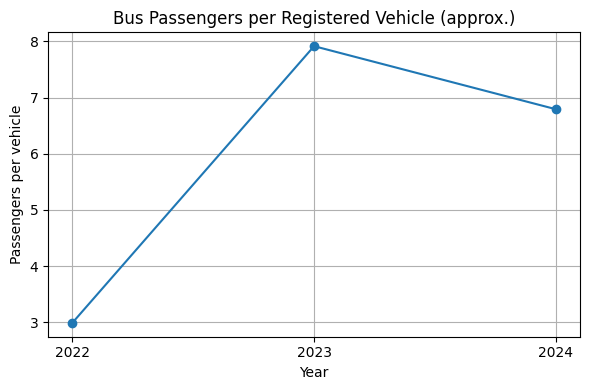

In [27]:
plt.figure(figsize=(6, 4))

years = merged["year"].astype(int)

plt.plot(years, merged["passengers_per_vehicle"], marker="o")
plt.title("Bus Passengers per Registered Vehicle (approx.)")
plt.xlabel("Year")
plt.ylabel("Passengers per vehicle")
plt.grid(True)

plt.xticks(years)

plt.tight_layout()
plt.show()

## 6. Key insights (to explain to the audience)

Once you run the notebook, you can adapt the numbers, but the typical messages will look like:

- **Registered vehicles are increasing** steadily between 2022 and 2024  
  → puts more pressure on **road capacity and safety**.

- **Bus passengers within cities grew very fast** from 2021 to 2023,  
  with a slight drop in 2024  
  → shows that public transport is starting to play a **bigger role**, but also needs stability.

- A small number of cities (likely **Makkah, Riyadh, Jeddah, Eastern Region cities**)  
  account for the **majority of bus passengers**,  
  which matches where congestion and safety issues are more intense.

- Comparing **bus passengers per vehicle**:
  - If the curve is going **up**, this suggests that public transport use is growing **faster** than vehicle ownership → supportive for congestion and safety.
  - If the curve is going **down**, it shows that private vehicles are **outpacing** bus usage → more pressure on roads.

These insights are easy to turn into:

- A short **memo paragraph** on national land transport trends.
- One or two **slides** with charts and bullet points that connect directly to  
  your topic: **Traffic Safety & Infrastructure Optimization in Saudi Arabia**.

You can now tweak labels (e.g., “Saudi Arabia – Land Transport Overview 2021–2024”),  
highlight Riyadh where useful, and connect this to where you will later bring in  
**accidents, congestion, and policy options (sensors, congestion zones, etc.)**.